Initializing reader and loading graph...
Assigning speed and travel times for edges...
Simplifying graph...
Plotting graph...


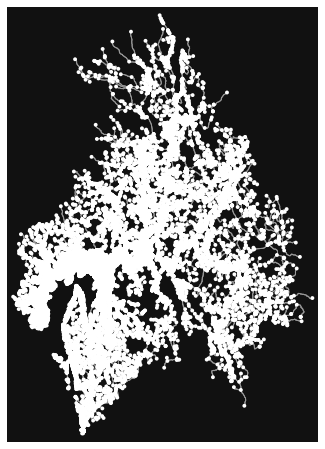

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [1]:
from pyrosm import OSM
import osmnx as ox
import networkx as nx

print("Initializing reader and loading graph...")
# Initialize the reader
osm = OSM("data/osm/oslo_akershus_highways.osm.pbf")
# Read nodes and edges of the 'driving' network
nodes, edges = osm.get_network(nodes=True, network_type="driving")
# Create NetworkX graph
G = osm.to_graph(nodes, edges, graph_type="networkx")

print("Assigning speed and travel times for edges...")
# Assign speeds to edges missing data based on dict values.
# For edges with highway type not in dict, impute speeds.
hwy_speeds = {'motorway': 80,
              'trunk': 70,
              'primary': 50,
              'secondary': 40,
              'tertiary': 40,
              'unclassified': 40,
              'residential': 30}
# Add speed and calculate travel time for edges
G = ox.add_edge_speeds(G, hwy_speeds)
G = ox.add_edge_travel_times(G)

print("Simplifying graph...")
# remove geometry attribute from edges as simplify will create it
for n1, n2, d in G.edges(data=True):
    d.pop('geometry', None)
# remove unnecessary nodes
G = ox.simplify_graph(G, False, True)

print("Plotting graph...")
ox.plot_graph(G)

451


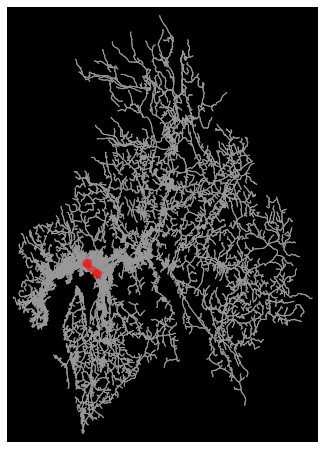

In [2]:
lat_a, lon_a = 59.93199541091416, 10.717662400595254
lat_b, lon_b = 59.9029054935812, 10.771425158205664

a = ox.nearest_nodes(G, lon_a, lat_a)
b = ox.nearest_nodes(G, lon_b, lat_b)

# Find shortest path (by travel time)
route = nx.shortest_path(G, a, b, weight="travel_time")

# travel time
travel_time = 0
for u, v in zip(route[:-1], route[1:]):
    travel_time += G.edges[(u, v, 0)]['travel_time']
travel_time = round(travel_time)
print(travel_time)

# plot route
fig, ax = ox.plot_graph_route(G, route, route_linewidth=6, node_size=0, bgcolor='k')